In [3]:
%load_ext autoreload
%autoreload 2


In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
sys.path.append("/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset/code")
# from BigGANdeep_nodist import Generator
from BigGAN_nodist import Generator
BGEco_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/biggan-pytorch-ecoset"

In [2]:
suffix = "best2"
config = torch.load(join(BGEco_root, "weights", f"state_dict_{suffix}.pth"))['config']
weights_dict = torch.load(join(BGEco_root, "weights", f"G_{suffix}.pth"))
G = Generator(**config)
G.load_state_dict(weights_dict, strict=True)
G.to("cuda").eval()
G.requires_grad_(False);

Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 82179971


In [4]:
from torchvision.utils import make_grid
device = "cuda"

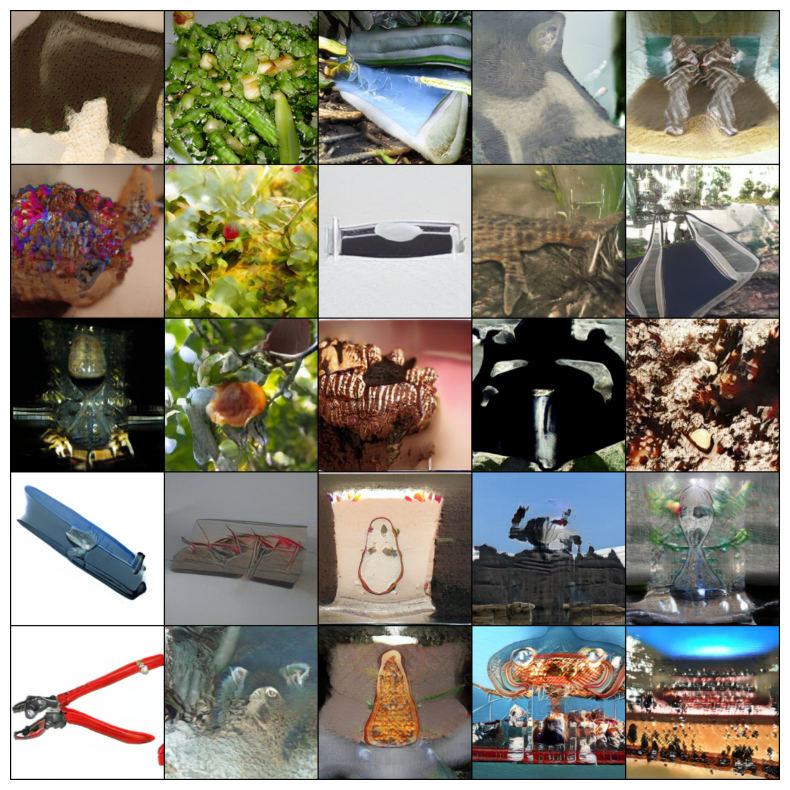

In [5]:
# custom sampling, seems equivalent
batch_size = 25
zs = torch.randn(batch_size, 140).to(device)
ys = torch.randint(0, 565, (batch_size,), dtype=torch.long, device=device)
with torch.no_grad():
    imgs = G.forward(zs, G.shared(ys)).cpu()

grid = make_grid((imgs + 1) / 2, nrow=5)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

### Evolution demo

In [30]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")
from circuit_toolkit.dataset_utils import create_imagenet_valid_dataset
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, saveallforms, save_imgrid
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet,RGB_mean
from circuit_toolkit.Optimizers import CholeskyCMAES, CholeskyCMAES_torch, CholeskyCMAES_torch_noCMA
from circuit_toolkit.CNN_scorers import TorchScorer, resize_and_pad, resize_and_pad_tsr
from circuit_toolkit.layer_hook_utils import featureFetcher, featureFetcher_module
import torchvision

RGB_mean = torch.tensor([0.485, 0.456, 0.406]) #.view(1,-1,1,1).cuda()
RGB_std  = torch.tensor([0.229, 0.224, 0.225]) #.view(1,-1,1,1).cuda()
IN_transform = torchvision.transforms.Compose([
                                            # torchvision.transforms.Resize(256, ),
                                            # torchvision.transforms.CenterCrop((256, 256), ),
                                            torchvision.transforms.Normalize(RGB_mean, RGB_std)])


In [26]:
total_steps = 100 
print_freq = 10
unit_idx = 10
layerkey = "fc8"
RFresize = False

In [27]:
CNN = TorchScorer("resnet50_linf8", )
CNN.model

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
class BigGAN_EcoSet_Wrapper(nn.Module):
    def __init__(self, G, ):
        super().__init__()
        self.G = G
        self.latent_shape = (140 + 128, )
        self.codelen = 140 + 128
    
    def visualize(self, latent_codes):
        ys = latent_codes[:, :128]
        zs = latent_codes[:, 128:]
        imgs = self.G.forward(zs, ys)
        imgs = (imgs + 1) / 2
        return imgs


G_wrp = BigGAN_EcoSet_Wrapper(G, )

In [70]:
unit_idx = 1
layerkey = "fc"
fetcher = featureFetcher_module()
fetcher.record_module(CNN.model.fc, target_name=layerkey)
# fetcher.record_module(CNN.net.__getattr__(layerkey), target_name=layerkey)
# G = G_dict[GAN_key]
code_len = G_wrp.codelen # 140 + 128
# use the mean of the layer activation as initialization
# new_codes = activ_mean[GAN_key][None, ...].flatten(start_dim=1) ##[unit_idx]
# init_sigma = activ_std[GAN_key].mean().item() * std_scaling_factor
init_code_std = 0.01
init_sigma = 0.05
assert not np.isnan(init_sigma)
optimizer = CholeskyCMAES_torch_noCMA(code_len, init_sigma=init_sigma, Aupdate_freq=1000, device='cuda')
new_codes = init_code_std * torch.randn(1, code_len, device='cuda') #np.random.randn(1, code_len)
scores_all = []
generations = []
codes_all = []
best_imgs = []
with torch.no_grad():
    for i in range(total_steps,):
        codes_all.append(new_codes.cpu().numpy())
        latent_code = new_codes.view(-1, *G_wrp.latent_shape)
        imgs = G_wrp.visualize(latent_code)#.cuda().cpu()
        if RFresize:
            imgs = resize_and_pad_tsr(imgs, imgsize, corner, canvas_size=imgsize, )  #  Bug: imgs are resized to 256x256 and it will be further resized in score_tsr
        # preprocess the image
        imgs_pp = IN_transform(imgs)
        CNN.model(imgs_pp, )
        activations = fetcher[layerkey]
        if activations.ndim == 2:
            scores = activations[:, unit_idx] #.cpu().numpy() #scorer.score_tsr(imgs)
        elif activations.ndim == 4:
            center_idx = tuple(dim // 2 for dim in activations.shape[-2:])
            scores = activations[:, unit_idx, center_idx[0], center_idx[1]]
        else:
            raise ValueError(f"Unsupported activation dimension: {activations.ndim}")
        if i % print_freq == 0 or i == total_steps - 1:
            print("step %d score %.3f (%.3f) (norm %.2f )" % (
                i, scores.mean().cpu(), scores.std().cpu(), latent_code.view(-1, code_len).norm(dim=1).mean().cpu(),))
        new_codes = optimizer.step_simple(scores, new_codes, verbosity=False)
        scores_all.extend(list(scores.cpu().numpy()))
        generations.extend([i] * len(scores))
        best_imgs.append(imgs[scores.argmax(),:,:,:].cpu())

Space dimension: 268, Population size: 28, Select size:14, Optimization Parameters:
Initial sigma: 0.050
cc=0.015, cs=0.148, c1=0.000, damps=1.148
step 0 score -0.333 (nan) (norm 0.16 )


/tmp/ipykernel_4033023/3587035779.py:40: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  i, scores.mean().cpu(), scores.std().cpu(), latent_code.view(-1, code_len).norm(dim=1).mean().cpu(),))


step 10 score 4.857 (0.699) (norm 1.16 )
step 20 score 8.289 (0.817) (norm 1.56 )
step 30 score 11.109 (1.556) (norm 2.02 )
step 40 score 12.546 (1.871) (norm 2.34 )
step 50 score 14.013 (1.292) (norm 2.55 )
step 60 score 14.615 (1.583) (norm 2.72 )
step 70 score 14.875 (1.464) (norm 2.98 )
step 80 score 15.126 (2.067) (norm 3.22 )
step 90 score 15.766 (1.820) (norm 3.31 )
step 99 score 16.242 (1.523) (norm 3.40 )


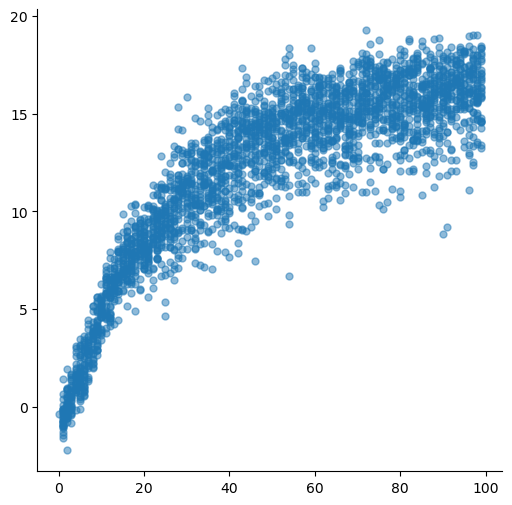

In [71]:
plt.figure(figsize=(6, 6))
plt.scatter(generations, scores_all, s=25, alpha=0.5)
plt.show()

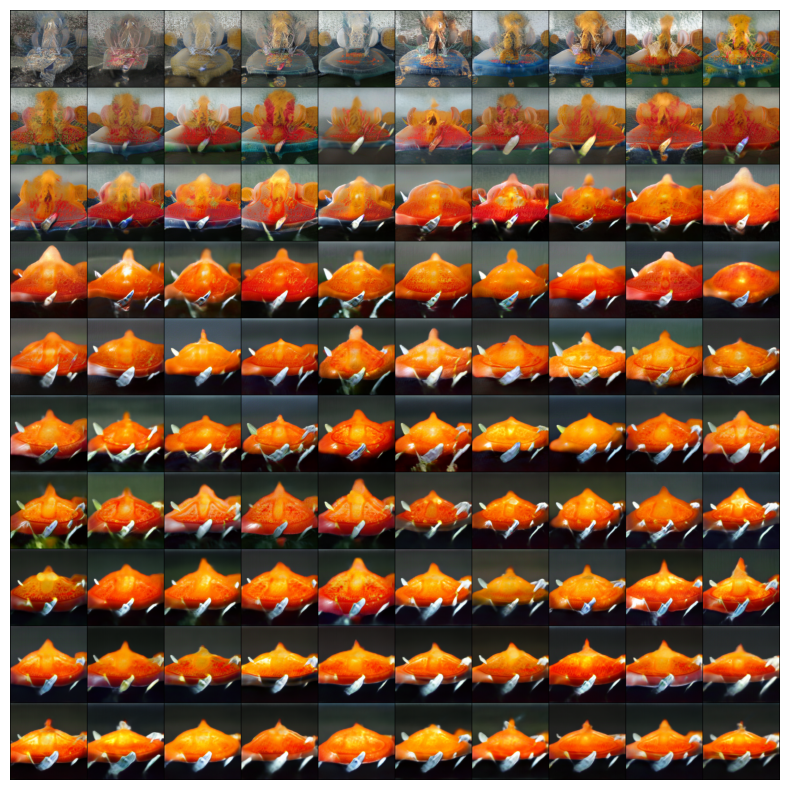

In [72]:
mtg = to_imgrid(best_imgs, nrow=10)
plt.figure(figsize=(10, 10))
plt.imshow(mtg)
plt.axis('off')
plt.show()

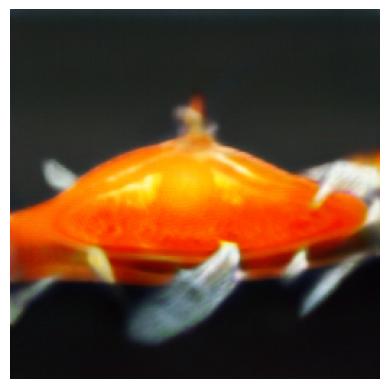

In [73]:
plt.imshow(best_imgs[-1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()